# Sampling BPT

Linear fitting continnum spectrum 的時候是用的 py_contsub_linefree.ipynb 作為湯底  
但 pixel 是從 CARTA 採樣來的，方法參考如下  

- method ref :  
老豆，說取幾個代表性的點做 BPT ratio 就好  
真的假的？  

- IFU from :  
ESO Arcnive   
Instrument          : VLT MUSE(single)  
Object              : Circinus  
Range(air $\lambda$): 4759-9320 Å（補藥換成頻率啊）      
pID                 : 094.B-0321

In [175]:
# modular
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.io import fits

## Set up

### Import data
讀進來的東西是確切的三維

In [176]:
c = 299792.458  # [km/s]
z = 0.001448 # circinus galaxy
commonPath = '/Users/aqing/Documents/1004/Circinus_galaxy/ionized-gas/VLT/'
file_path = f"{commonPath}MUSE_PID-094.B-0321_cube_4750-9352a_circinus.fits" # FITS

# metadata
muse_hdul = fits.open(file_path)
#muse_hdul.info() # DATA:cube, STAT:noise?
muse_data = muse_hdul['DATA'].data # (RA, DEC, AWAV), 3D desu
muse_header = muse_hdul['DATA'].header

### 又來到了親愛的波長軸的環節了
稍微切了一下，因為旁邊用不太到

In [177]:
# entire AWV axis
crval3 = muse_header['CRVAL3']
cdelt3 = muse_header['CD3_3']
crpix3 = muse_header['CRPIX3']
naxis3 = muse_header['NAXIS3']
ori_lamb = crval3 + (np.arange(naxis3) + 1 - crpix3) * cdelt3 # [AA] in air

# analysis range
wmin, wmax = 4751, 6900 # [AA]
WLrange = (ori_lamb >= wmin) & (ori_lamb <= wmax) # '&' is a numpy operator!

# 切一下
lamb = ori_lamb[WLrange]
muse_partiData = muse_data[WLrange, :, :]

### Line free channel (wave lengh)
where_is_linefree 是人類去圈的，可能在中心區比較正確...  
(旁邊的 absorbtion 是不是有點太多了)

In [178]:
# line free channs
where_is_linefree = [(4770.796, 4834.046), # [AA] in air
                     (5326.546, 5494.046),
                     (5612.796, 5757.796),
                     (5996.546, 6137.796),
                     (6400.296, 6475.296),
                     (6646.546, 6686.546),
                     (6757.796, 6807.796),
                     (7117.796, 7205.296)]

# 之前做過的對獎邏輯！但是忘記是在哪做的了啊啊
lineFree_channs = []
for i in range(int(lamb.shape[0])): # 做一個都是 0 的對獎紙
    lineFree_channs.append(0) 

fitting_lamb = []
for i in range(len(lamb)): # 在指定的 line free 區的話，就標記 1
    wav = float(lamb[i])
    for m, M in where_is_linefree:
        if wav>m and wav<M:
            lineFree_channs[i] = 1 # 畫記，因為 flux 那邊還要用
            fitting_lamb.append(lamb[i]) # 會拿去做 fiiting 的波長點，擔任 scipy 中 x 的角色
fitting_lamb = np.array(fitting_lamb)

### Emission lines profile
到時候要標記發射線在哪兒就有東西可以標  
直接寫成封包了嘿嘿，但與子圖不相容

In [179]:
emission_lines = [('H-beta*', (1+z)*4861), # 為什麼分兩邊寫因為我是瓠瓜
                  ('O[III]_4958', (1+z)*4958), 
                  ('O[III]_5007*', (1+z)*5007),
                  ('H-alpha*', (1+z)*6562),
                  ('N[II]_6548', (1+z)*6548),
                  ('N[II]_6583*', (1+z)*6583),
                  ('O[I]', (1+z)*6300),
                  #('Ar[III]', (1+z)*7135),
                  ('S[II]_6716', (1+z)*6716),
                  ('S[II]_6730', (1+z)*6730)]

# 輸入 ymax 以達到最佳顯示效果
def Plot_emission(ymax):
    for n, l in emission_lines :
        plt.axvline(l, color='r', linestyle="-", lw=0.7)
        if  '*' in n :
            c='b'
            plt.text(l, ymax*0.9, n, rotation=90, color=c, fontsize=10, ha='right', va='top')
        else :
            c='k'
        plt.axvline(l, color=c, linestyle="-", lw=0.7)


### **Choosen pixels
選一些像素，取樣的意思啦

In [180]:
# 要 fit 哪個 pixel 的 continnum?
sampling_pixels = [(168, 176), (100, 189)]

## Fitting
先用的超簡單超乎天文的 fitting  
不知道對不對但 fit 得挺好啊

### fitting function
對這個環境高度相依的函式  
離開這裡之後的可用性是0  
裡面的 fitModel, lamb 都是寫死的，這只是用來讓我的程式不要長成一坨用的  

- 輸入：要進行連續譜線性擬合的 pixel 的光譜 (串列). 
- 回傳：fit 出來的連續譜(fitting_result, a list),  
       原始的東西減掉連續譜之後的東西，簡稱發射譜線(emission_contsub, a list)

In [181]:
# aqing's fitting function
def fitModel(x, a, b): # 先定個線性
    return a * x + b

def Continnum_fitting(fitting_pixel):
    fitting_flux = [] # 存放 fit 材料
    for i in range(len(lamb)):
        if lineFree_channs[i] == 1: # 對獎紙的用途
            fitting_flux.append(fitting_pixel[i])
    fitting_flux = np.array(fitting_flux)

    popt, _ = curve_fit(fitModel, fitting_lamb, fitting_flux, absolute_sigma=False) # least square
    fitting_result = fitModel(fitting_lamb, *popt) # 進行一個大代入，愛實驗物理學
    emission_contsub = fitting_pixel - (fitModel(lamb, *popt))
    return fitting_result, emission_contsub

### do the fitting
做擬合，順便取出擬合結果了！

In [182]:
# DO fit
contiL = []
emiiL = []
fluxL = [] # 每次的pixx要存起來畫圖

for raP, decP in sampling_pixels:
    pixx = muse_partiData[:, raP, decP]
    fluxL.append(pixx)
    conti, emii = Continnum_fitting(pixx)
    contiL.append(conti)
    emiiL.append(emii)

## Results demo

### fitting & contsub

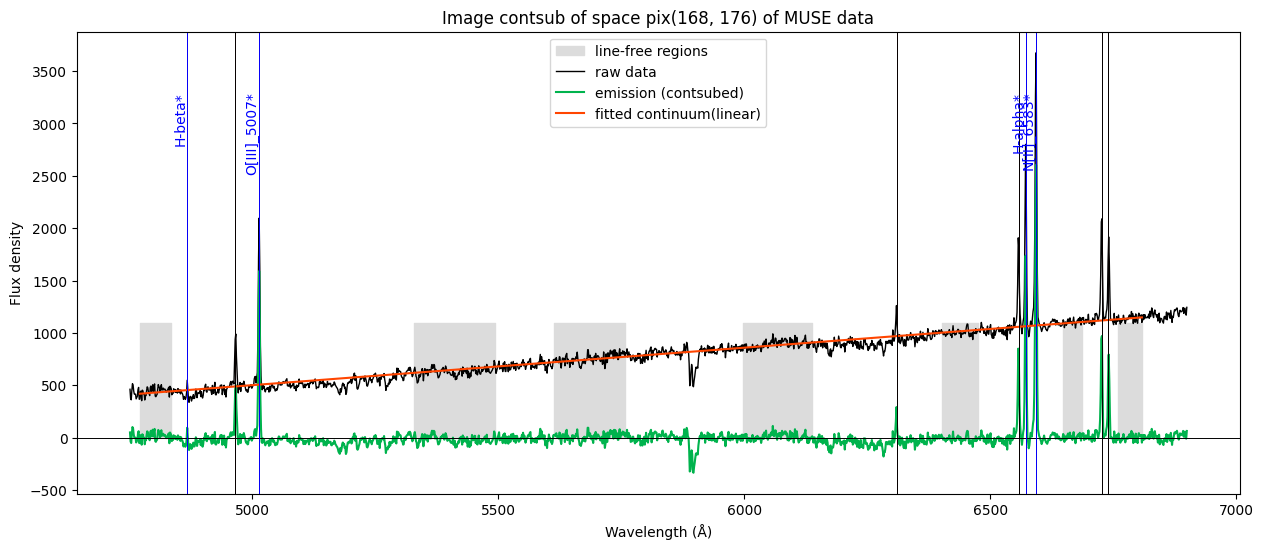

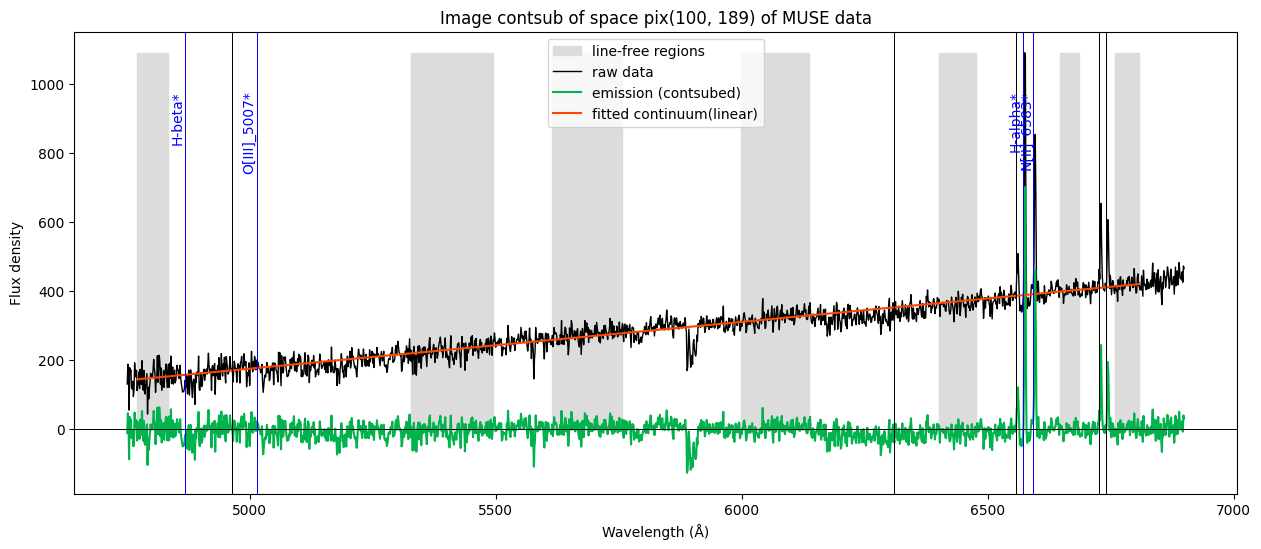

In [184]:
# 畫個
for i in range(len(contiL)):
    plt.figure(figsize=(15, 6))
    plt.fill_between(lamb, -1, np.max(pixx), where=lineFree_channs, # 灰色格子是這樣做的
                    color='gainsboro', label="line-free regions")
    plt.plot(lamb, fluxL[i], c='k', lw=1, label='raw data')
    plt.plot(lamb, emiiL[i], c=(0, 0.7, 0.3), label='emission (contsubed)')
    plt.plot(fitting_lamb, contiL[i], c='orangered', label="fitted continuum(linear)")

    plt.axhline(0, c='k', lw=0.7)
    plt.xlabel("Wavelength (Å)")
    plt.ylabel("Flux density")
    plt.title(f'Image contsub of space pix({sampling_pixels[i][0]}, {sampling_pixels[i][1]}) of MUSE data')
    Plot_emission(np.max(fluxL[i]))

    plt.legend(loc='upper center')
    plt.show()
